# Ejemplo de regresión lineal con regularización


### 1. Delitos
Predecir el número de crímenes violentos a partir de un conjunto de aspectos poblacionales: porcentaje de la población considerada urbana y el ingreso familiar medio, y la participación de las fuerzas del orden público, como el número per cápita de agentes de policía y el porcentaje de agentes asignados a las unidades de drogas, etc.

https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime

In [26]:
import pandas as pd
import utilis

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')


import warnings
warnings.filterwarnings('ignore')

### Conjunto de datos

Se tiene 122 variables explicativas y una variable respuesta **crímenes violentos**.

In [27]:
# descargamos los datos
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data'
crime = pd.read_csv(url, header=None, na_values=['?'])
crime.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03


In [28]:
# eliminamos los primeras 5 columnas informativas, y los valores faltantess
crime.drop([0, 1, 2, 3, 4], axis=1, inplace=True)
crime.dropna(inplace=True)

In [29]:
# define X and y
X = crime.drop(127, axis=1)
y = crime[127]

In [30]:
X.shape

(319, 122)

In [31]:
y.shape

(319,)

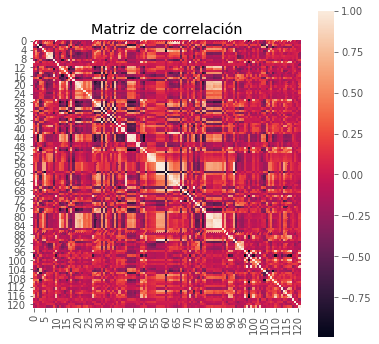

In [32]:
# matriz de correlacion
corr_matrix = np.corrcoef(X.T)
# mapa de calor
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.heatmap(corr_matrix, square=True, ax=ax)
ax.set_title("Matriz de correlación")
plt.show()

Muchas de las variables están altamente correlacionadas (correlación absoluta $> 0.8$), lo que supone un problema a la hora de emplear modelos de regresión lineal.

# Modelación

In [33]:
# division de los datos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=19970808)

### Mínimos cuadrados (OLS)

El error (rmse) de test es: 0.30798558936771414


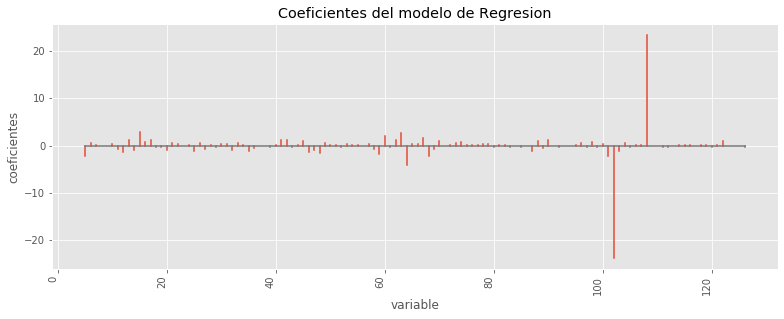

In [34]:
# ajustamos el modelo
reg = LinearRegression(normalize=True)
reg.fit(X = X_train, y = y_train)

# creamos el dataframe de coefficientes
rmse_ols = graficar_coeficientes_y_rmse(reg, "Regresion")


### Rigde
Busqueda de nuestro hiperparametro de regularización.

In [35]:
rigde = RidgeCV(alphas=np.logspace(-4, 2, 200), fit_intercept=True, normalize=True, store_cv_values=True)

_ = rigde.fit(X = X_train, y = y_train)

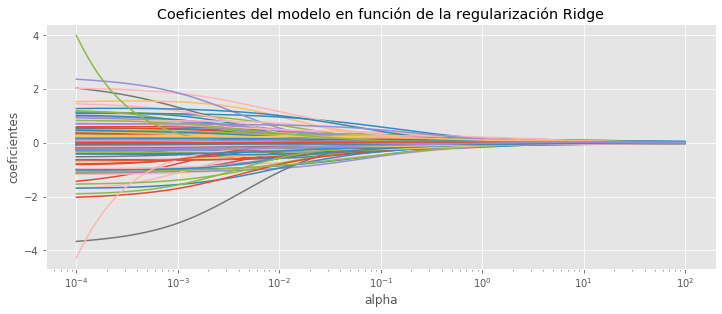

In [36]:
alphas = rigde.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_)

fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización Ridge');
plt.axis('tight')
plt.show()

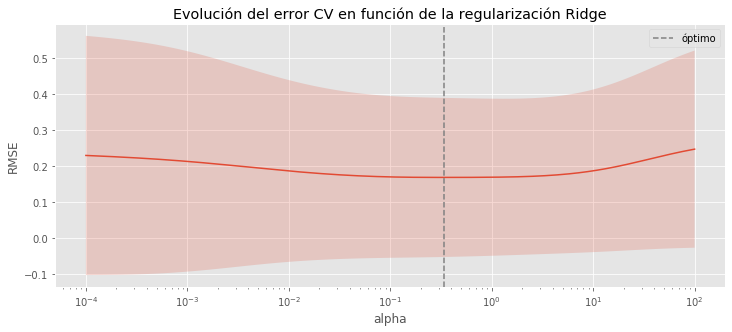

In [37]:
graficar_rmse_evolucion(rigde, "Ridge")

Mejor valor de alpha encontrado: 0.33700643292719284
El error (rmse) de test es: 0.17746209028303883


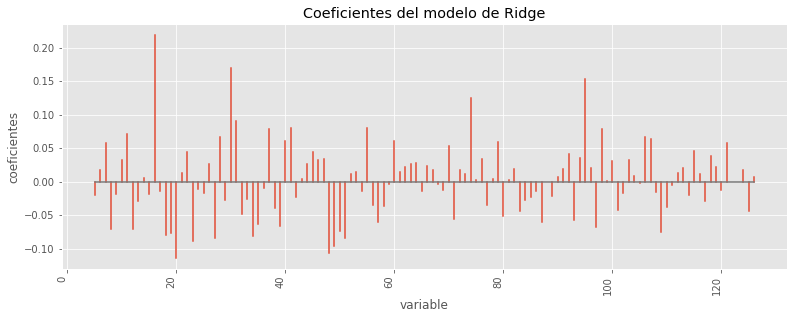

In [38]:
print(f"Mejor valor de alpha encontrado: {rigde.alpha_}")

rmse_ridge = graficar_coeficientes_y_rmse(rigde, "Ridge")

### LASSO

In [20]:
?np.logspace

In [15]:
lasso = LassoCV(alphas=np.logspace(-4, 1, 200), normalize=True, cv = 10)
_ = lasso.fit(X = X_train, y = y_train)

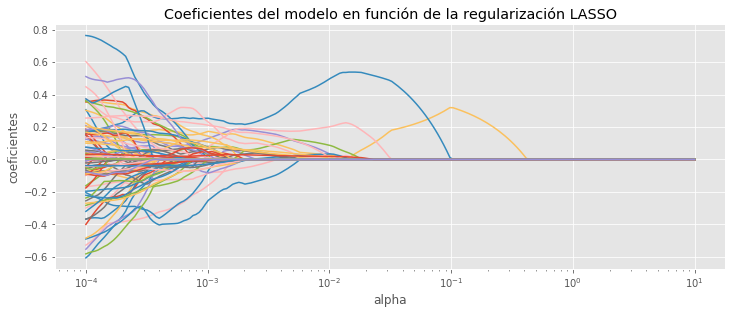

In [21]:
alphas = lasso.alphas_
coefs = []
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False, normalize=True)
    modelo_temp.fit(X_train, y_train)
    coefs.append(modelo_temp.coef_)
    coef_no_cero = np.sum(modelo_temp.coef_!= 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización LASSO');

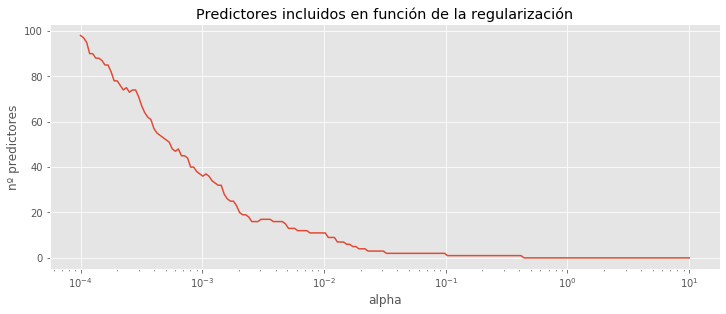

In [22]:
fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

Mejor valor de alpha encontrado: 0.0006010276782070381


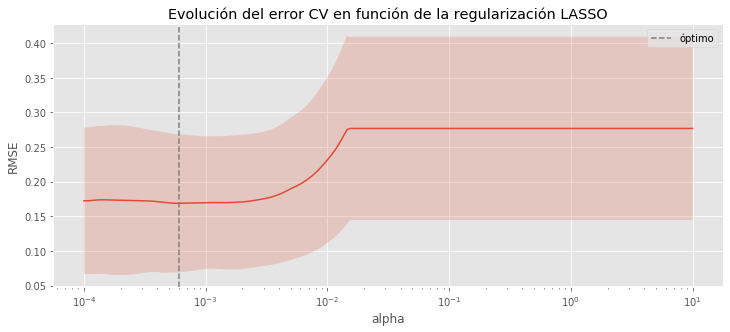

In [23]:
graficar_rmse_evolucion(lasso, "LASSO")

print(f"Mejor valor de alpha encontrado: {lasso.alpha_}")

El error (rmse) de test es: 0.16563275654685422


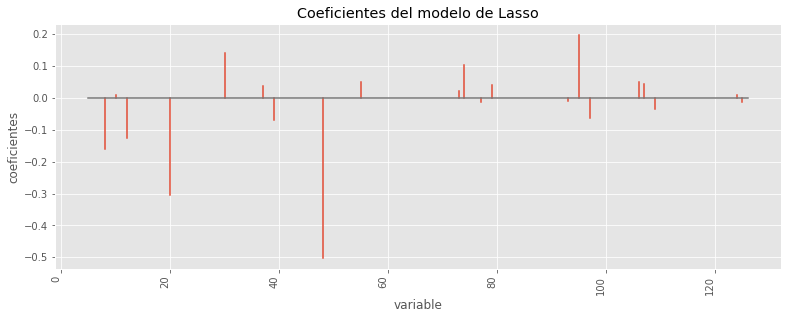

In [24]:
rmse_lasso = graficar_coeficientes_y_rmse(lasso, "Lasso")

### Elastic Net

In [25]:
elas_net = ElasticNetCV(l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99], alphas=np.logspace(-10, 3, 200),
                        normalize=True, cv=10, n_jobs=-1)
_ = elas_net.fit(X = X_train, y = y_train)

In [23]:
print(f"Mejor valor de alpha encontrado: {elas_net.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {elas_net.l1_ratio_}")

Mejor valor de alpha encontrado: 0.001783430876931913
Mejor valor de l1_ratio encontrado: 0.0


El error (rmse) de test es: 0.17631549076778055


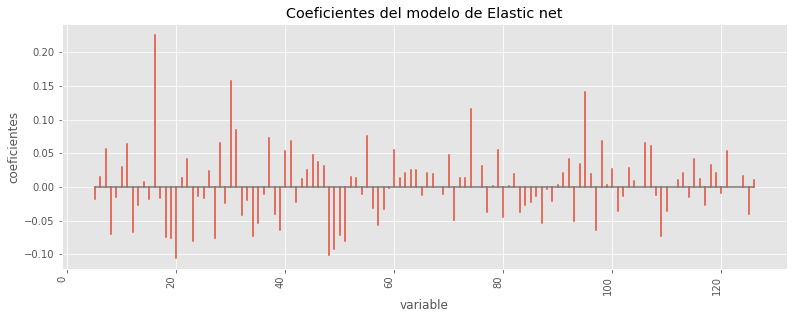

In [25]:
rmse_elastic = graficar_coeficientes_y_rmse(elas_net, "Elastic net")

# Comparación de los errores

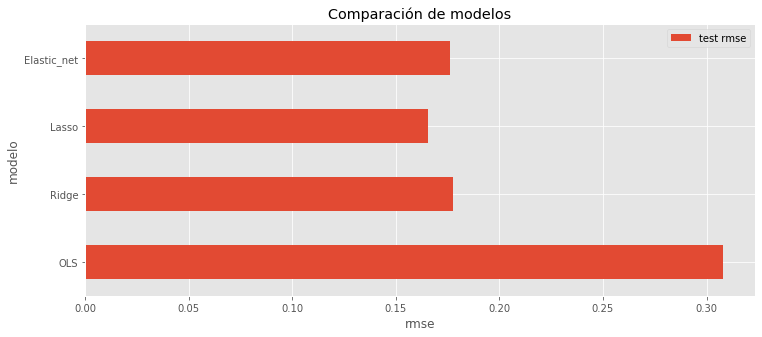

In [27]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', "Elastic_net"],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(12, 5))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

### 2. Contenido de grasa en carne

El departamento de calidad de una empresa de alimentación se encarga de medir el contenido en grasa de la carne que comercializa. Este estudio se realiza mediante técnicas de analítica química, un proceso relativamente costoso en tiempo y recursos. Una alternativa que permitiría reducir costes y optimizar tiempo es emplear un espectrofotómetro (instrumento capaz de detectar la absorbancia que tiene un material a diferentes tipos de luz en función de sus características) e inferir el contenido en grasa a partir de sus medidas.



Antes de dar por válida esta nueva técnica, la empresa necesita comprobar qué margen de error tiene respecto al análisis químico. Para ello, se mide el espectro de absorbancia a 100 longitudes de onda en 215 muestras de carne, cuyo contenido en grasa se obtiene también por análisis químico, y se entrena un modelo con el objetivo de predecir el contenido en grasa a partir de los valores dados por el espectrofotómetro.

In [28]:
datos = pd.read_csv('data/meatspec.csv')
datos = datos.drop(columns = datos.columns[0])
datos.info()

X = datos.drop(columns='fat')
y = datos['fat']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Columns: 101 entries, V1 to fat
dtypes: float64(101)
memory usage: 169.8 KB


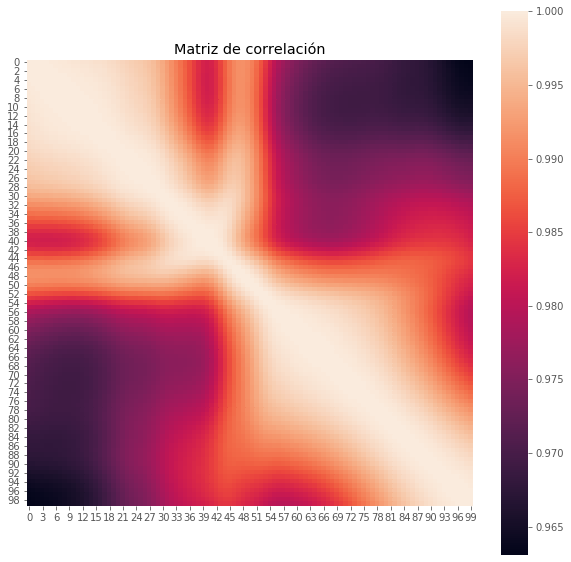

In [29]:
# matriz de correlacion
corr_matrix = np.corrcoef(X.T)

# mapa de calor
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
sns.heatmap(corr_matrix, square=True, ax=ax)
ax.set_title("Matriz de correlación")
plt.show()

In [30]:
# modificamos los algunos datos
col_prueba = ["V{}".format(i) for i in range(80,100)]
X[col_prueba]= X[col_prueba]*10000

In [31]:
## partimos el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y.values.reshape(-1,1), train_size=0.7, random_state=19970808)

In [34]:
# ajustamos los modelos
# Regresión lineal
reg = LinearRegression(normalize=False)
reg.fit(X = X_train, y = y_train)
predicciones = reg.predict(X=X_test)
rmse_ols = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)

# LASSO
lasso = LassoCV(alphas=np.logspace(-7, 3, 200), normalize=False, cv = 10, n_jobs=-1)
_ = lasso.fit(X = X_train, y = y_train)
predicciones = lasso.predict(X=X_test)
rmse_lasso = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)

# Ridge
rigde = RidgeCV(alphas=np.logspace(-7, 2, 200), fit_intercept=True, normalize=False, store_cv_values=True)
_ = rigde.fit(X = X_train, y = y_train)
predicciones = rigde.predict(X=X_test)
rmse_ridge = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)

# Elastic net
elas_net = ElasticNetCV(l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99], alphas=np.logspace(-10, 3, 200),
                        normalize=True, cv=10, n_jobs=-1)
_ = elas_net.fit(X = X_train, y = y_train)
predicciones = elas_net.predict(X=X_test)
rmse_elas_net = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)

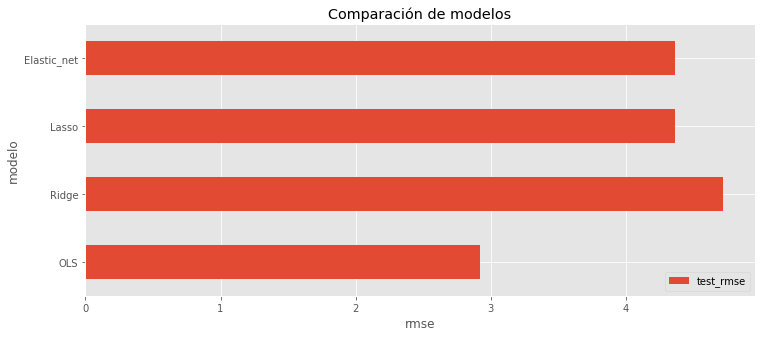

In [35]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', "Elastic_net"],
                    'test_rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elas_net],
                    'data': ["original", "original", "original", "original"]
                 })

fig, ax = plt.subplots(figsize=(12, 5))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');

In [36]:
# ajustamos los modelos
# estandarizamos.
std = StandardScaler()
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

# Regresión lineal
reg = LinearRegression(normalize=False)
reg.fit(X = X_train, y = y_train)
predicciones = reg.predict(X=X_test)
rmse_ols = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)

# LASSO
lasso = LassoCV(alphas=np.logspace(-1, 3, 200), normalize=False, cv = 10, n_jobs=-1)
_ = lasso.fit(X = X_train, y = y_train)
predicciones = lasso.predict(X=X_test)
rmse_lasso = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)

# Ridge
rigde = RidgeCV(alphas=np.logspace(-7, 2, 200), fit_intercept=True, normalize=False, store_cv_values=True)
_ = rigde.fit(X = X_train, y = y_train)
predicciones = rigde.predict(X=X_test)
rmse_ridge = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)

# Elastic net
elas_net = ElasticNetCV(l1_ratio=[0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99], alphas=np.logspace(-10, 3, 200),
                        normalize=True, cv=10, n_jobs=-1)
_ = elas_net.fit(X = X_train, y = y_train)
predicciones = elas_net.predict(X=X_test)
rmse_elas_net = mean_squared_error(y_true=y_test, y_pred=predicciones, squared=False)

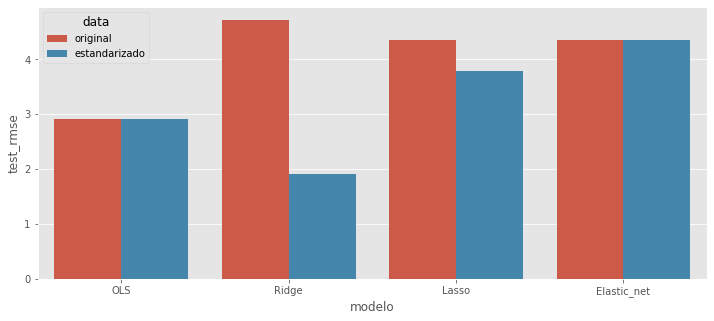

In [37]:
df_comparacion2 = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', "Elastic_net"],
                    'test_rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elas_net],
                    "data": ["estandarizado", "estandarizado", "estandarizado", "estandarizado"]
                 })


df_comparacion_new = pd.concat([df_comparacion, df_comparacion2])

fig, ax = plt.subplots(figsize=(12, 5))
ax = sns.barplot(x="modelo", y="test_rmse", hue="data", data=df_comparacion_new)

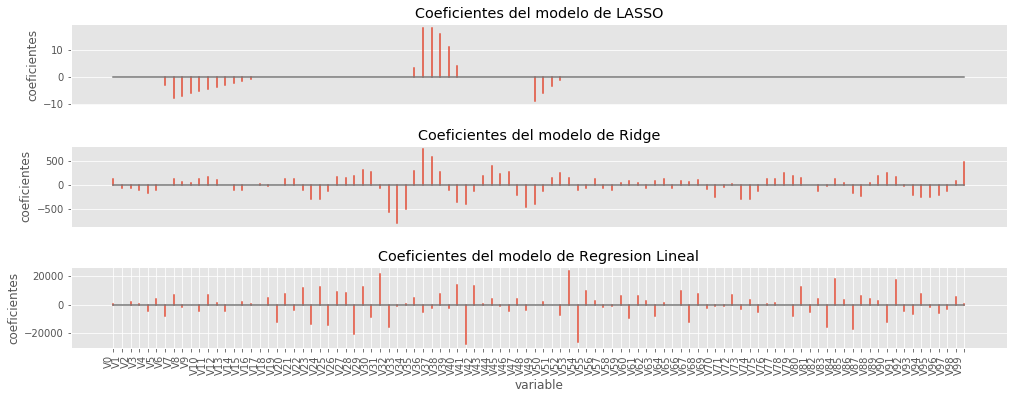

In [38]:
variables = ["V{}".format(i) for i in range(X.shape[1])]
# creamos un dataframe con los coeficientes
df_coeficientes = pd.DataFrame({'predictor': variables, 'coef': lasso.coef_})
df_coeficientes2 = pd.DataFrame({'predictor': variables, 'coef': rigde.coef_[0]})
df_coeficientes3 = pd.DataFrame({'predictor': variables, 'coef': reg.coef_[0]})

# graficamos los coeficientes
fig, ax = plt.subplots(nrows=3, figsize=(13, 4.5))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=.5, wspace=2)

ax[0].stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')    
ax[0].set_xticks([])
ax[0].set_xlabel(' ')
ax[0].set_ylabel('coeficientes')
ax[0].set_title('Coeficientes del modelo de {}'.format("LASSO"))

ax[1].stem(df_coeficientes2.predictor, df_coeficientes2.coef, markerfmt=' ')    
ax[1].set_xticks([])
ax[1].set_xlabel(' ')
ax[1].set_ylabel('coeficientes')
ax[1].set_title('Coeficientes del modelo de {}'.format("Ridge"))

ax[2].stem(df_coeficientes3.predictor, df_coeficientes3.coef, markerfmt=' ')    
plt.xticks(rotation=90, ha='right', size=10)
ax[2].set_xlabel('variable')
ax[2].set_ylabel('coeficientes')
ax[2].set_title('Coeficientes del modelo de {}'.format("Regresion Lineal"))
plt.show()

In [39]:
sum(lasso.coef_!=0)

22

In [40]:
sum(rigde.coef_[0]!=0)

100

In [41]:
sum(reg.coef_[0]!=0)

100

### Referencias
- U. S. Department of Commerce, Bureau of the Census, Census Of Population And Housing 1990 United States: Summary Tape File 1a & 3a (Computer Files),

- U.S. Department Of Commerce, Bureau Of The Census Producer, Washington, DC and Inter-university Consortium for Political and Social Research Ann Arbor, Michigan. (1992)

- U.S. Department of Justice, Bureau of Justice Statistics, Law Enforcement Management And Administrative Statistics (Computer File) U.S. Department Of Commerce, Bureau Of The Census Producer, Washington, DC and Inter-university Consortium for Political and Social Research Ann Arbor, Michigan. (1992)

- U.S. Department of Justice, Federal Bureau of Investigation, Crime in the United States (Computer File) (1995)

- Redmond, M. A. and A. Baveja: A Data-Driven Software Tool for Enabling Cooperative Information Sharing Among Police Departments. European Journal of Operational Research 141 (2002) 660-678.

- J.J. Faraway.Extending the Linear Model with R: Generalized Linear, Mixed Effects and Nonparametric RegressionModels. CRC Press, 2006.

- Regularización Ridge, Lasso y Elastic Net con Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html

- https://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/regularization/regularization.ipynb